In [1]:
%matplotlib inline


# Thunderstorm Detection and Tracking - T-DaTing

This example shows how to use the thunderstorm DaTing module. The example is based on
MeteoSwiss radar data and uses the Cartesian composite of maximum reflectivity on a
1 km grid. All default values are tuned to this grid, but can be modified.
The first section demonstrates thunderstorm cell detection and how to plot contours.
The second section demonstrates detection and tracking in combination,
as well as how to plot the resulting tracks.
This module was implemented following the procedures used in the TRT Thunderstorms
Radar Tracking algorithm (:cite:`TRT2004`) used operationally at MeteoSwiss.
Modifications include advecting the identified thunderstorms with the optical flow
obtained from pysteps, as well as additional options in the thresholding. A detailed
description is published in Appendix A of :cite:`Feldmann2021`.

## References
:cite:`TRT2004`
:cite:`Feldmann2021`

@author: feldmann-m


### Import all required functions



In [2]:
from datetime import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

from pysteps import io, rcparams
from pysteps.feature import tstorm as tstorm_detect
from pysteps.tracking import tdating as tstorm_dating
from pysteps.utils import to_reflectivity
from pysteps.visualization import plot_precip_field, plot_track, plot_cart_contour

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



### Read the radar input images

A series of 20 files containing Swiss Cartesian gridded rain rates are imported. Since
the algorithm is tuned to Swiss max-reflectivity data, the rain rates are transformed
to reflectivity fields using the 'to_reflectivity' utility in pysteps.utils.



In [3]:
# Select the input data
date = datetime.strptime("201607112100", "%Y%m%d%H%M")
data_source = rcparams.data_sources["mch"]

# Extract corresponding settings
root_path = data_source["root_path"]
path_fmt = data_source["path_fmt"]
fn_pattern = data_source["fn_pattern"]
fn_ext = data_source["fn_ext"]
importer_name = data_source["importer"]
importer_kwargs = data_source["importer_kwargs"]
timestep = data_source["timestep"]

# Load the data from the archive
fns = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep, num_next_files=20
)
importer = io.get_method(importer_name, "importer")
R, _, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

# Convert to reflectivity (it is possible to give the a- and b- parameters of the
# Marshall-Palmer relationship here: zr_a = and zr_b =).
Z, metadata = to_reflectivity(R, metadata)

# Extract the list of timestamps
timelist = metadata["timestamps"]

pprint(metadata)

{'accutime': 5,
 'cartesian_unit': 'm',
 'institution': 'MeteoSwiss',
 'product': 'AQC',
 'projection': '+proj=somerc  +lon_0=7.43958333333333 +lat_0=46.9524055555556 '
               '+k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel '
               '+towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs',
 'threshold': -4.062281309285625,
 'timestamps': array([datetime.datetime(2016, 7, 11, 21, 0),
       datetime.datetime(2016, 7, 11, 21, 5),
       datetime.datetime(2016, 7, 11, 21, 10),
       datetime.datetime(2016, 7, 11, 21, 15),
       datetime.datetime(2016, 7, 11, 21, 20),
       datetime.datetime(2016, 7, 11, 21, 25),
       datetime.datetime(2016, 7, 11, 21, 30),
       datetime.datetime(2016, 7, 11, 21, 35),
       datetime.datetime(2016, 7, 11, 21, 40),
       datetime.datetime(2016, 7, 11, 21, 45),
       datetime.datetime(2016, 7, 11, 21, 50),
       datetime.datetime(2016, 7, 11, 21, 55),
       datetime.datetime(2016, 7, 11, 22, 0),
       datetime.datetime(2016, 7, 1

### Example of thunderstorm identification in a single timestep
The function tstorm_detect.detection requires a 2-D input image, all further inputs are
optional.



In [4]:
input_image = Z[2, :, :].copy()
time = timelist[2]
cells_id, labels = tstorm_detect.detection(input_image, time=time)

Properties of one of the identified cells:



In [5]:
print(cells_id.iloc[0])

ID                                                         1
time                                     2016-07-11 21:10:00
x          [464, 465, 466, 467, 468, 469, 470, 471, 472, ...
y          [115, 115, 115, 115, 115, 115, 115, 115, 115, ...
cen_x                                                    463
cen_y                                                    119
max_ref                                            47.437719
cont       [[[128.2, 448.0], [128.0, 447.8], [127.2, 447....
area                                                     176
Name: 0, dtype: object


### Example of thunderstorm tracking over a timeseries
The tstorm-dating function requires the entire pre-loaded time series.
The first two timesteps are required to initialize the
flow prediction and are not used to compute tracks.



In [6]:
track_list, cell_list, label_list = tstorm_dating.dating(
    input_video=Z, timelist=timelist
)

### Plotting the results



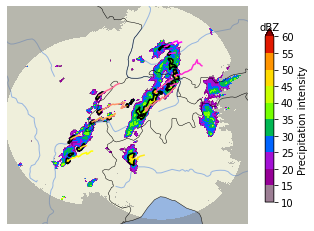

In [7]:
# Plot precipitation field
plot_precip_field(Z[2, :, :], geodata=metadata, units=metadata["unit"])
plt.xlabel("Swiss easting [m]")
plt.ylabel("Swiss northing [m]")

# Add the identified cells
plot_cart_contour(cells_id.cont, geodata=metadata)

# Filter the tracks to only contain cells existing in this timestep
IDs = cells_id.ID.values
track_filt = []
for track in track_list:
    if np.unique(track.ID) in IDs:
        track_filt.append(track)

# Add their tracks
plot_track(track_filt, geodata=metadata)
plt.show()

### Evaluating temporal behaviour of cell
Maximum reflectivity of cells in time



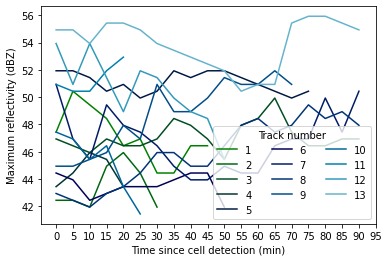

In [8]:
# Make an empty list
tlen = []
# Get a list of colors that we will use for the plot
color = iter(plt.cm.ocean(np.linspace(0, 0.8, len(track_filt))))
# Now, loop through all the tracks and plot the maximum reflectivity of the cell
# in time.
for track in track_filt:
    plt.plot(np.arange(len(track)), track.max_ref, c=next(color))
    tlen.append(len(track))
plt.xticks(np.arange(max(tlen) + 1), labels=np.arange(max(tlen) + 1) * 5)
plt.ylabel("Maximum reflectivity (dBZ)")
plt.xlabel("Time since cell detection (min)")
plt.legend(IDs, loc="lower right", ncol=3, title="Track number")
plt.show()

The size of the thunderstorm cells in time



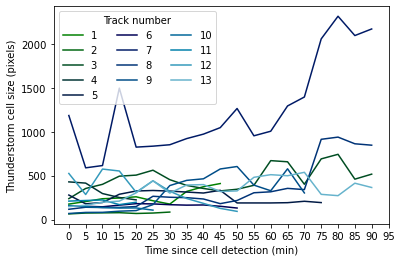

In [9]:
# Make an empty list
tlen = []
# Get a list of colors that we will use for the plot
color = iter(plt.cm.ocean(np.linspace(0, 0.8, len(track_filt))))
# Now, loop through all the tracks and plot the cell size of the thunderstorms
# in time.
for track in track_filt:
    size = []
    for ID, t in track.iterrows():
        size.append(len(t.x))
    plt.plot(np.arange(len(track)), size, c=next(color))
    tlen.append(len(track))
plt.xticks(np.arange(max(tlen) + 1), labels=np.arange(max(tlen) + 1) * 5)
plt.ylabel("Thunderstorm cell size (pixels)")
plt.xlabel("Time since cell detection (min)")
plt.legend(IDs, loc="upper left", ncol=3, title="Track number")
plt.show()